In [1]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.2 MB/s eta 0:00:00


In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt

In [10]:
# Download sample Bitcoin data from Yahoo Finance
btc_data = yf.download("BTC-USD", start="2021-01-01", end="2022-01-01")

# Use 'Adj Close' if available, otherwise fall back to 'Close'
if 'Adj Close' in btc_data.columns:
    price_series = btc_data['Adj Close']
else:
    price_series = btc_data['Close']

price_series = price_series.dropna()

# Compute log returns in per cent
returns = 100 * np.log(price_series / price_series.shift(1)).dropna()

# Define parameter grids for mean, volatility and distribution
mean_models = ['Constant', 'AR']
vol_models = ['GARCH', 'EGARCH']
dists = ['normal', 't']

results = []

# Loop through all combinations of the parameters
for mean in mean_models:
    for vol in vol_models:
        for dist in dists:
            print(f"Fitting model with mean: {mean}, vol: {vol}, dist: {dist}")

            # Set lags to 1 for an AR mean, otherwise no lags.
            lags = 1 if mean == 'AR' else 0

            # -----------------------------
            # Fit model using the full dataset
            try:
                model_full = arch_model(returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
                res_full = model_full.fit(disp='off')
                # For EGARCH, use simulation-based forecasting since analytic forecasts for horizon > 1 are not available
                if vol == 'EGARCH':
                    forecast_full = res_full.forecast(horizon=5, method='simulation', simulations=500, reindex=False)
                else:
                    forecast_full = res_full.forecast(horizon=5, reindex=False)
                # Convert forecast variance to volatility (square root of variance)
                vol_forecast_full = np.sqrt(forecast_full.variance.values[-1, :])
            except Exception as e:
                print(f"Error fitting full model: {e}")
                vol_forecast_full = None

            # -----------------------------
            # Fit model using the training dataset (without the last 5 days)
            train_returns = returns.iloc[:-5]
            try:
                model_train = arch_model(train_returns, mean=mean, lags=lags, vol=vol, p=1, q=1, dist=dist)
                res_train = model_train.fit(disp='off')
                if vol == 'EGARCH':
                    forecast_train = res_train.forecast(horizon=5, method='simulation', simulations=500, reindex=False)
                else:
                    forecast_train = res_train.forecast(horizon=5, reindex=False)
                vol_forecast_train = np.sqrt(forecast_train.variance.values[-1, :])
            except Exception as e:
                print(f"Error fitting train model: {e}")
                vol_forecast_train = None

            # -----------------------------
            # Calculate forecasting error as the mean absolute difference between the two forecasts
            if vol_forecast_full is not None and vol_forecast_train is not None:
                forecast_error = np.mean(np.abs(vol_forecast_full - vol_forecast_train))
            else:
                forecast_error = np.nan

            results.append({
                'mean': mean,
                'vol': vol,
                'dist': dist,
                'vol_forecast_full': vol_forecast_full,
                'vol_forecast_train': vol_forecast_train,
                'forecast_error': forecast_error
            })

# Compile the results into a DataFrame for inspection
results_df = pd.DataFrame(results)
print(results_df)

[*********************100%***********************]  1 of 1 completed


Fitting model with mean: Constant, vol: GARCH, dist: normal
Fitting model with mean: Constant, vol: GARCH, dist: t
Fitting model with mean: Constant, vol: EGARCH, dist: normal
Fitting model with mean: Constant, vol: EGARCH, dist: t
Fitting model with mean: AR, vol: GARCH, dist: normal
Fitting model with mean: AR, vol: GARCH, dist: t
Fitting model with mean: AR, vol: EGARCH, dist: normal
Fitting model with mean: AR, vol: EGARCH, dist: t
       mean     vol    dist  \
0  Constant   GARCH  normal   
1  Constant   GARCH       t   
2  Constant  EGARCH  normal   
3  Constant  EGARCH       t   
4        AR   GARCH  normal   
5        AR   GARCH       t   
6        AR  EGARCH  normal   
7        AR  EGARCH       t   

                                   vol_forecast_full  \
0  [3.543746355136154, 3.553887557194752, 3.56371...   
1  [3.545904660039442, 3.556670237659748, 3.56710...   
2  [3.5590978605427934, 3.5743029358318137, 3.588...   
3  [3.57744276694339, 3.592501176219786, 3.606530...   


Ticker           BTC-USD
Date                    
2021-01-01  29374.152344
2021-01-02  32127.267578
2021-01-03  32782.023438
2021-01-04  31971.914062
2021-01-05  33992.429688
...                  ...
2021-12-27  50640.417969
2021-12-28  47588.855469
2021-12-29  46444.710938
2021-12-30  47178.125000
2021-12-31  46306.445312

[365 rows x 1 columns]


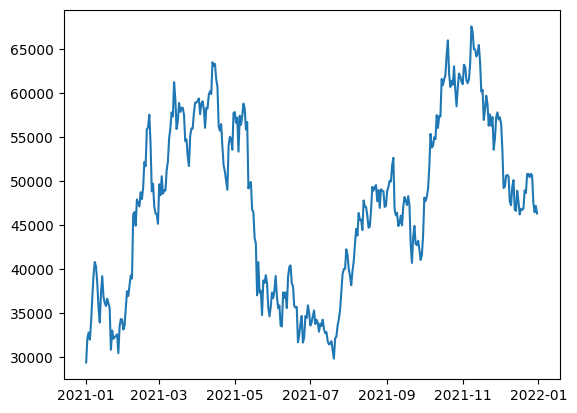

In [11]:
print(price_series)
plt.plot(price_series)
plt.show()